In [7]:
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
from math import sqrt
import time

def initializeWeights(n_in, n_out):
    """
    # initializeWeights return the random weights for Neural Network given the
    # number of node in the input layer and output layer

    # Input:
    # n_in: number of nodes of the input layer
    # n_out: number of nodes of the output layer

    # Output:
    # W: matrix of random initial weights with size (n_out x (n_in + 1))"""

    epsilon = sqrt(6) / sqrt(n_in + n_out + 1)
    W = (np.random.rand(n_out, n_in + 1) * 2 * epsilon) - epsilon
    return W


def sigmoid(z):
    """# Notice that z can be a scalar, a vector or a matrix
    # return the sigmoid of input z"""

    return 1 / (1 + np.exp(-z)) # your code here


def preprocess():
    """ Input:
     Although this function doesn't have any input, you are required to load
     the MNIST data set from file 'mnist_all.mat'.

     Output:
     train_data: matrix of training set. Each row of train_data contains
       feature vector of a image
     train_label: vector of label corresponding to each image in the training
       set
     validation_data: matrix of training set. Each row of validation_data
       contains feature vector of a image
     validation_label: vector of label corresponding to each image in the
       training set
     test_data: matrix of training set. Each row of test_data contains
       feature vector of a image
     test_label: vector of label corresponding to each image in the testing
       set

     Some suggestions for preprocessing step:
     - feature selection"""

    mat = loadmat('mnist_all.mat')  # loads the MAT object as a Dictionary

    # Pick a reasonable size for validation data

    # ------------Initialize preprocess arrays----------------------#
    train_preprocess = np.zeros(shape=(50000, 784))
    validation_preprocess = np.zeros(shape=(10000, 784))
    test_preprocess = np.zeros(shape=(10000, 784))
    train_label_preprocess = np.zeros(shape=(50000,))
    validation_label_preprocess = np.zeros(shape=(10000,))
    test_label_preprocess = np.zeros(shape=(10000,))
    # ------------Initialize flag variables----------------------#
    train_len = 0
    validation_len = 0
    test_len = 0
    train_label_len = 0
    validation_label_len = 0
    # ------------Start to split the data set into 6 arrays-----------#
    for key in mat:
        # -----------when the set is training set--------------------#
        if "train" in key:
            label = key[-1]  # record the corresponding label
            tup = mat.get(key)
            sap = range(tup.shape[0])
            tup_perm = np.random.permutation(sap)
            tup_len = len(tup)  # get the length of current training set
            tag_len = tup_len - 1000  # defines the number of examples which will be added into the training set

            # ---------------------adding data to training set-------------------------#
            train_preprocess[train_len:train_len + tag_len] = tup[tup_perm[1000:], :]
            train_len += tag_len

            train_label_preprocess[train_label_len:train_label_len + tag_len] = label
            train_label_len += tag_len

            # ---------------------adding data to validation set-------------------------#
            validation_preprocess[validation_len:validation_len + 1000] = tup[tup_perm[0:1000], :]
            validation_len += 1000

            validation_label_preprocess[validation_label_len:validation_label_len + 1000] = label
            validation_label_len += 1000

            # ---------------------adding data to test set-------------------------#
        elif "test" in key:
            label = key[-1]
            tup = mat.get(key)
            sap = range(tup.shape[0])
            tup_perm = np.random.permutation(sap)
            tup_len = len(tup)
            test_label_preprocess[test_len:test_len + tup_len] = label
            test_preprocess[test_len:test_len + tup_len] = tup[tup_perm]
            test_len += tup_len
            # ---------------------Shuffle,double and normalize-------------------------#
    train_size = range(train_preprocess.shape[0])
    train_perm = np.random.permutation(train_size)
    train_data = train_preprocess[train_perm]
    train_data = np.double(train_data)
    train_data = train_data / 255.0
    train_label = train_label_preprocess[train_perm]

    validation_size = range(validation_preprocess.shape[0])
    vali_perm = np.random.permutation(validation_size)
    validation_data = validation_preprocess[vali_perm]
    validation_data = np.double(validation_data)
    validation_data = validation_data / 255.0
    validation_label = validation_label_preprocess[vali_perm]

    test_size = range(test_preprocess.shape[0])
    test_perm = np.random.permutation(test_size)
    test_data = test_preprocess[test_perm]
    test_data = np.double(test_data)
    test_data = test_data / 255.0
    test_label = test_label_preprocess[test_perm]

    # Feature selection
    # Your code here.
    # Feature selection
    non_zero_variance_features = train_data.var(axis=0) != 0
    train_data = train_data[:, non_zero_variance_features]
    validation_data = validation_data[:, non_zero_variance_features]
    test_data = test_data[:, non_zero_variance_features]

    selected_features_indices = np.where(non_zero_variance_features)[0]

    # Write selected features to a file
    with open("selected_features_indices.txt", "w") as f:
        for index in selected_features_indices:
            f.write(f"{index}\n")

    print('preprocess done')

    return train_data, train_label, validation_data, validation_label, test_data, test_label


def nnObjFunction(params, *args):
    """% nnObjFunction computes the value of objective function (negative log
    %   likelihood error function with regularization) given the parameters
    %   of Neural Networks, thetraining data, their corresponding training
    %   labels and lambda - regularization hyper-parameter.

    % Input:
    % params: vector of weights of 2 matrices w1 (weights of connections from
    %     input layer to hidden layer) and w2 (weights of connections from
    %     hidden layer to output layer) where all of the weights are contained
    %     in a single vector.
    % n_input: number of node in input layer (not include the bias node)
    % n_hidden: number of node in hidden layer (not include the bias node)
    % n_class: number of node in output layer (number of classes in
    %     classification problem
    % training_data: matrix of training data. Each row of this matrix
    %     represents the feature vector of a particular image
    % training_label: the vector of truth label of training images. Each entry
    %     in the vector represents the truth label of its corresponding image.
    % lambda: regularization hyper-parameter. This value is used for fixing the
    %     overfitting problem.

    % Output:
    % obj_val: a scalar value representing value of error function
    % obj_grad: a SINGLE vector of gradient value of error function
    % NOTE: how to compute obj_grad
    % Use backpropagation algorithm to compute the gradient of error function
    % for each weights in weight matrices.

    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    % reshape 'params' vector into 2 matrices of weight w1 and w2
    % w1: matrix of weights of connections from input layer to hidden layers.
    %     w1(i, j) represents the weight of connection from unit j in input
    %     layer to unit i in hidden layer.
    % w2: matrix of weights of connections from hidden layer to output layers.
    %     w2(i, j) represents the weight of connection from unit j in hidden
    %     layer to unit i in output layer."""

    n_input, n_hidden, n_class, training_data, training_label, lambdaval = args

    w1 = params[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
    w2 = params[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))
    obj_val = 0

    # Your code here
    #
    #
    #
    #
    #
    # Add bias to training data
    training_data = np.hstack([training_data, np.ones((training_data.shape[0], 1))])

    # Forward pass
    hidden_layer_input = np.dot(training_data, w1.T)
    hidden_layer_output = sigmoid(hidden_layer_input)
    hidden_layer_output = np.hstack([hidden_layer_output, np.ones((hidden_layer_output.shape[0], 1))])

    output_layer_input = np.dot(hidden_layer_output, w2.T)
    output_layer_output = sigmoid(output_layer_input)

    # Convert labels to one-hot encoding if not already
    # Convert labels to one-hot encoding if not already
    if training_label.ndim == 1:
        # Ensure training_label is an integer array
        training_label = training_label.astype(int)

        training_label_onehot = np.zeros((training_label.size, n_class))
        training_label_onehot[np.arange(training_label.size), training_label] = 1
    else:
        training_label_onehot = training_label

    # Error calculation using negative log likelihood
    error_term = -np.sum(training_label_onehot * np.log(output_layer_output) +
                        (1 - training_label_onehot) * np.log(1 - output_layer_output))

    # Regularization term
    reg_term = (lambdaval / 2) * (np.sum(np.square(w1)) + np.sum(np.square(w2)))

    # Total objective function value
    obj_val = (error_term / training_data.shape[0]) + reg_term

    # Backpropagation to compute gradients
    delta_output = output_layer_output - training_label_onehot
    grad_w2 = np.dot(delta_output.T, hidden_layer_output) / training_data.shape[0]

    delta_hidden = np.dot(delta_output, w2) * hidden_layer_output * (1 - hidden_layer_output)
    grad_w1 = np.dot(delta_hidden.T[:-1], training_data) / training_data.shape[0]

    # Regularize gradients
    grad_w1 += (lambdaval * w1) / training_data.shape[0]
    grad_w2 += (lambdaval * w2) / training_data.shape[0]

    # Flatten gradients into a single vector
    obj_grad = np.concatenate((grad_w1.flatten(), grad_w2.flatten()), 0)




    # Make sure you reshape the gradient matrices to a 1D array. for instance if your gradient matrices are grad_w1 and grad_w2
    # you would use code similar to the one below to create a flat array
    # obj_grad = np.concatenate((grad_w1.flatten(), grad_w2.flatten()),0)


    return (obj_val, obj_grad)


def nnPredict(w1, w2, data):
    """% nnPredict predicts the label of data given the parameter w1, w2 of Neural
    % Network.

    % Input:
    % w1: matrix of weights of connections from input layer to hidden layers.
    %     w1(i, j) represents the weight of connection from unit i in input
    %     layer to unit j in hidden layer.
    % w2: matrix of weights of connections from hidden layer to output layers.
    %     w2(i, j) represents the weight of connection from unit i in input
    %     layer to unit j in hidden layer.
    % data: matrix of data. Each row of this matrix represents the feature
    %       vector of a particular image

    % Output:
    % label: a column vector of predicted labels"""

    labels = np.array([])
    # Your code here
    expected_features = w1.shape[1] - 1
    if data.shape[1] != expected_features:
        raise ValueError(f"Input data has incorrect shape: {data.shape[1]} features, expected {expected_features}")

    # Add bias unit to input data
    data = np.hstack([data, np.ones((data.shape[0], 1))])

    # Compute input to hidden layer
    hidden_layer_input = np.dot(data, w1.T)

    # Compute output from hidden layer using sigmoid activation
    hidden_layer_output = sigmoid(hidden_layer_input)

    # Add bias unit to hidden layer output
    hidden_layer_output = np.hstack([hidden_layer_output, np.ones((hidden_layer_output.shape[0], 1))])

    # Compute input to output layer
    output_layer_input = np.dot(hidden_layer_output, w2.T)

    # Compute output from output layer using sigmoid activation
    output_layer_output = sigmoid(output_layer_input)

    # Determine predicted labels by finding index of maximum value in output layer
    labels = np.argmax(output_layer_output, axis=1)


    return labels


"""**************Neural Network Script Starts here********************************"""

train_data, train_label, validation_data, validation_label, test_data, test_label = preprocess()

#  Train Neural Network

# set the number of nodes in input unit (not including bias unit)
n_input = train_data.shape[1]

# set the number of nodes in hidden unit (not including bias unit)
n_hidden = 30

# set the number of nodes in output unit
n_class = 10

# initialize the weights into some random matrices
initial_w1 = initializeWeights(n_input, n_hidden)
initial_w2 = initializeWeights(n_hidden, n_class)

# unroll 2 weight matrices into single column vector
initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()), 0)

# set the regularization hyper-parameter
lambdaval = 0

args = (n_input, n_hidden, n_class, train_data, train_label, lambdaval)

# Train Neural Network using fmin_cg or minimize from scipy,optimize module. Check documentation for a working example
start_time = time.time()
opts = {'maxiter': 50}  # Preferred value.

nn_params = minimize(nnObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)

# In Case you want to use fmin_cg, you may have to split the nnObjectFunction to two functions nnObjFunctionVal
# and nnObjGradient. Check documentation for this function before you proceed.
# nn_params, cost = fmin_cg(nnObjFunctionVal, initialWeights, nnObjGradient,args = args, maxiter = 50)
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

# Reshape nnParams from 1D vector into w1 and w2 matrices
w1 = nn_params.x[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
w2 = nn_params.x[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))

# Test the computed parameters

predicted_label = nnPredict(w1, w2, train_data)

# find the accuracy on Training Dataset

print('\n Training set Accuracy:' + str(100 * np.mean((predicted_label == train_label).astype(float))) + '%')

predicted_label = nnPredict(w1, w2, validation_data)

# find the accuracy on Validation Dataset

print('\n Validation set Accuracy:' + str(100 * np.mean((predicted_label == validation_label).astype(float))) + '%')

predicted_label = nnPredict(w1, w2, test_data)

# find the accuracy on Validation Dataset

print('\n Test set Accuracy:' + str(100 * np.mean((predicted_label == test_label).astype(float))) + '%')



preprocess done
Training Time: 83.61 seconds

 Training set Accuracy:94.084%

 Validation set Accuracy:93.45%

 Test set Accuracy:93.84%


In [11]:
import pickle

# n_hidden: optimal number of units in hidden layer
# w1: trained weights for the input-to-hidden layer
# w2: trained weights for the hidden-to-output layer
# lambdaval: regularization parameter lambda
#optimal_n_hidden: optimal number of units in the hidden layer
#optimal_lambda: regularization coefficient λ

optimal_n_hidden = n_hidden
optimal_lambda = lambdaval
non_zero_variance_features = train_data.var(axis=0) != 0
selected_features_indices = np.where(non_zero_variance_features)[0]

data_to_save = {
    "optimal_n_hidden": optimal_n_hidden,
    "w1": w1,
    "w2": w2,
    "optimal_lambda": optimal_lambda,
    "selected_features": selected_features_indices
}

# Save to params.pickle
with open("params.pickle", "wb") as f:
    pickle.dump(data_to_save, f)

print("Parameters saved to params.pickle")


Parameters saved to params.pickle


In [12]:
import pickle

# Load the parameters from params.pickle
with open("params.pickle", "rb") as f:
    loaded_params = pickle.load(f)

# Print each parameter with a descriptive label
print("Loaded Parameters from params.pickle:")
for key, value in loaded_params.items():
    print(f"{key}:")
    print(value)
    print()


Loaded Parameters from params.pickle:
optimal_n_hidden:
30

w1:
[[-0.03379647 -0.07694139 -0.02901457 ... -0.03507685 -0.05407608
   0.08878509]
 [ 0.07487715  0.03503883 -0.00769305 ... -0.0143796   0.07957539
  -0.53491284]
 [ 0.08900421  0.03251727 -0.02567453 ...  0.00509893  0.05570719
  -0.42174679]
 ...
 [-0.00645921 -0.05619511 -0.02605496 ...  0.06530403 -0.02078296
  -0.64829636]
 [-0.03030864 -0.05036142  0.05902509 ...  0.04453366  0.07678576
  -0.71475851]
 [ 0.05797378 -0.0134937  -0.08249599 ... -0.08159344  0.02128002
   0.27246404]]

w2:
[[-1.85792582  0.96166869  1.88774196 -2.89281811 -1.1892609  -2.04355225
   0.32118813 -0.05581724 -1.5071852   0.43197807  0.95442155  1.86044505
  -2.4414006   0.81431536  0.07504677  0.74812417  0.72738271 -0.3629045
  -1.61028592  0.21531322 -1.0270637  -0.57972083 -1.05855215 -2.23442574
  -1.40849362  0.83526186  1.54090983 -0.52682865 -1.74437235  0.28443906
  -1.50428529]
 [ 1.11446879 -1.47140482  1.03044434 -0.16561517 -1.92

preprocess done


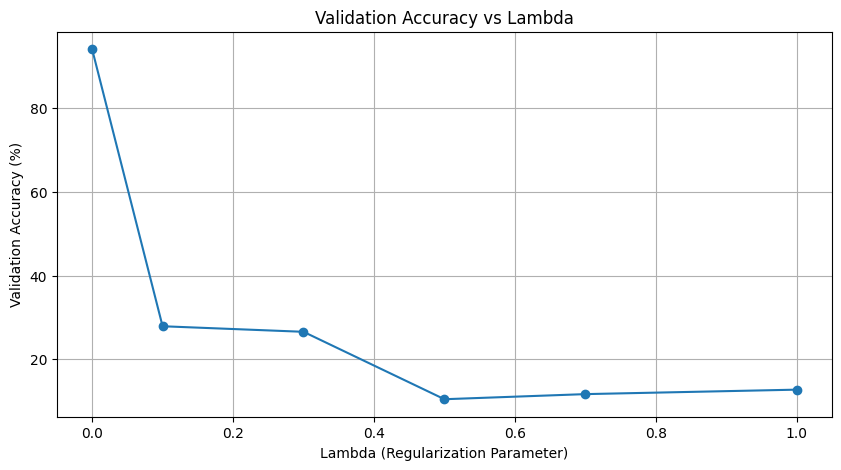

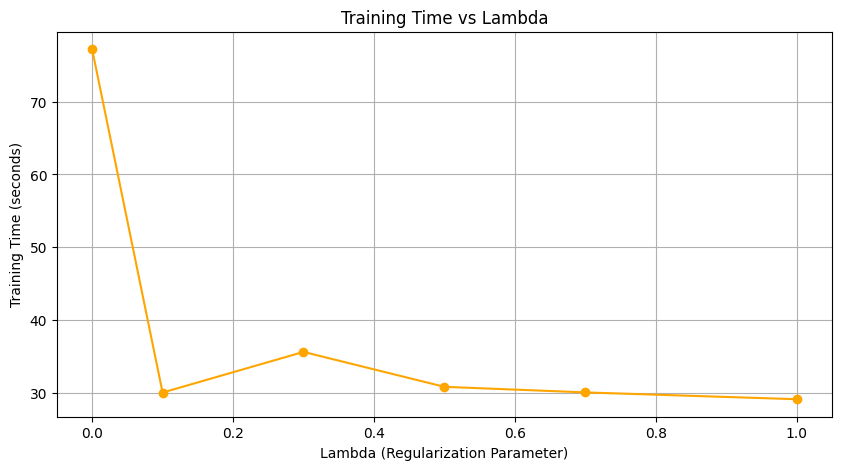

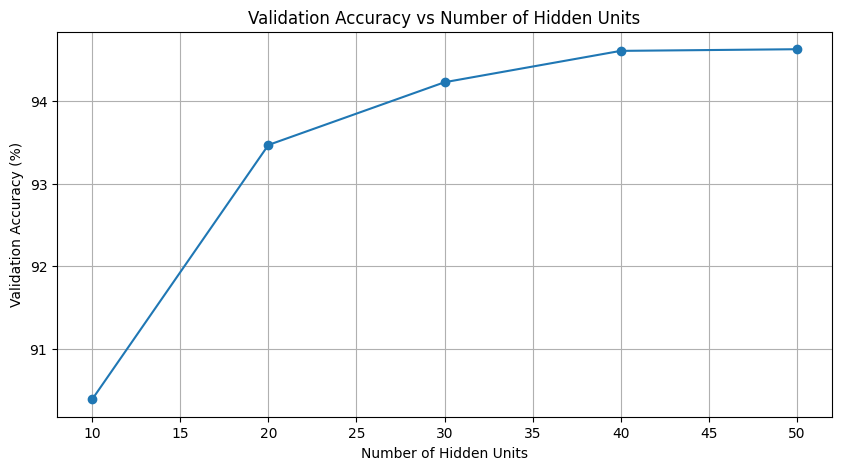

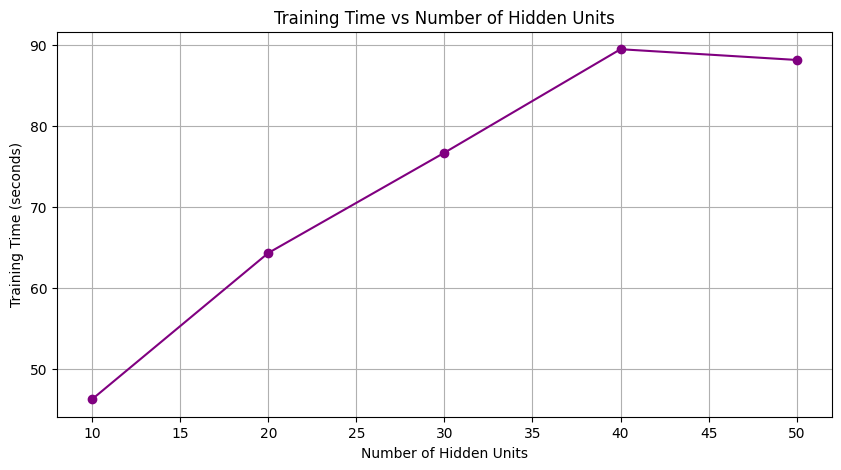

In [13]:
import matplotlib.pyplot as plt
import time
import numpy as np
from scipy.optimize import minimize

train_data, train_label, validation_data, validation_label, test_data, test_label = preprocess()
n_input = train_data.shape[1]
n_class = 10
lambdas = [0, 0.1, 0.3, 0.5, 0.7, 1.0]
hidden_units_list = [10, 20, 30, 40, 50]
lambda_accuracies = []
lambda_training_times = []
hidden_units_accuracies = []
hidden_units_training_times = []

# Set optimization options
opts = {'maxiter': 50}

# Test effect of lambda on performance
for lambdaval in lambdas:
    n_hidden = 30
    initial_w1 = initializeWeights(n_input, n_hidden)
    initial_w2 = initializeWeights(n_hidden, n_class)
    initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()), 0)
    args = (n_input, n_hidden, n_class, train_data, train_label, lambdaval)
    start_time = time.time()
    nn_params = minimize(nnObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)
    elapsed_time = time.time() - start_time
    # Reshape weights and predict on validation data
    w1 = nn_params.x[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
    w2 = nn_params.x[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))
    predicted_label = nnPredict(w1, w2, validation_data)
    accuracy = 100 * np.mean((predicted_label == validation_label).astype(float))
    # Record accuracy and training time
    lambda_accuracies.append(accuracy)
    lambda_training_times.append(elapsed_time)

# Plotting validation accuracy across lambda values
plt.figure(figsize=(10, 5))
plt.plot(lambdas, lambda_accuracies, marker='o')
plt.xlabel("Lambda (Regularization Parameter)")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy vs Lambda")
plt.grid(True)
plt.show()

# Plotting training time vs lambda values
plt.figure(figsize=(10, 5))
plt.plot(lambdas, lambda_training_times, marker='o', color='orange')
plt.xlabel("Lambda (Regularization Parameter)")
plt.ylabel("Training Time (seconds)")
plt.title("Training Time vs Lambda")
plt.grid(True)
plt.show()

# Test effect of number of hidden units on training time and accuracy
lambdaval = 0  # Fixed lambda for hidden units test
for n_hidden in hidden_units_list:
    initial_w1 = initializeWeights(n_input, n_hidden)
    initial_w2 = initializeWeights(n_hidden, n_class)
    initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()), 0)

    args = (n_input, n_hidden, n_class, train_data, train_label, lambdaval)
    start_time = time.time()
    nn_params = minimize(nnObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)
    elapsed_time = time.time() - start_time

    # Reshape weights and predict on validation data
    w1 = nn_params.x[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
    w2 = nn_params.x[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))
    predicted_label = nnPredict(w1, w2, validation_data)
    accuracy = 100 * np.mean((predicted_label == validation_label).astype(float))
    hidden_units_accuracies.append(accuracy)
    hidden_units_training_times.append(elapsed_time)

# Plotting validation accuracy across different hidden units
plt.figure(figsize=(10, 5))
plt.plot(hidden_units_list, hidden_units_accuracies, marker='o')
plt.xlabel("Number of Hidden Units")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy vs Number of Hidden Units")
plt.grid(True)
plt.show()

# Plotting training time vs number of hidden units
plt.figure(figsize=(10, 5))
plt.plot(hidden_units_list, hidden_units_training_times, marker='o', color='purple')
plt.xlabel("Number of Hidden Units")
plt.ylabel("Training Time (seconds)")
plt.title("Training Time vs Number of Hidden Units")
plt.grid(True)
plt.show()